In [54]:
from ranx import Run, evaluate, fuse
import numpy as np

In [55]:
import joblib

search_results = joblib.load("../workdir/rerank_ws/search_results.pkl.gz")
# search_results_with_target = joblib.load(
#     "../workdir/rerank_ws/search_results_debug.pkl.gz"
# )

In [56]:
target_dataset_name = "aio_01_test"

In [57]:
search_results = search_results_with_target[target_dataset_name]

In [58]:
len(search_results)

3

In [59]:
search_results[0]["indexes"].shape

(30, 500)

In [60]:
jacket_size = search_results[0]["indexes"].shape[0]
jacket_size

30

In [61]:
runs = []
for search_result in search_results:
    name = search_result["name"]
    print(name)
    scores = search_result["scores"]
    # score が高いほど良い、にするために反転
    scores = np.abs(search_result["scores"] - 1.0)
    indexes = search_result["indexes"]
    qids = search_result["qids"]
    run_dict = {}
    for id, score, index in zip(qids, scores, indexes):
        # id = str(id)
        # score = score.tolist()
        # index = index.tolist()
        index_score_dict = {}
        for s, pid in zip(score, index):
            index_score_dict[str(pid)] = s
        run_dict[id] = index_score_dict
    run = Run(run_dict, name=name)
    runs.append(run)

[debug]intfloat/multilingual-e5-large
[debug]cl-nagoya/sup-simcse-ja-base
[debug]pkshatech/GLuCoSE-base-ja


In [62]:
combined_run = fuse(
    runs=runs,  # A list of Run instances to fuse
    norm="min-max",  # The normalization strategy to apply before fusion
    method="rrf",  # The fusion algorithm to use
)

In [63]:
combined_data = combined_run.to_dict()

In [64]:
len(combined_data)

30

In [65]:
len(combined_data["0"])

0

In [66]:
import json
import os
import re
import time
import urllib.request
from argparse import ArgumentParser
from dataclasses import dataclass
from functools import lru_cache
from pathlib import Path
from time import time

import faiss
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset  # type: ignore
from tqdm import tqdm


WIKIPEDIA_JA_DS = "singletongue/wikipedia-utils"
WIKIPEDIA_JS_DS_NAME = "passages-c400-jawiki-20230403"
WIKIPEDIA_JA_EMB_DS = "hotchpotch/wikipedia-passages-jawiki-embeddings"


def get_wikija_ds(name: str = WIKIPEDIA_JS_DS_NAME):
    ds = load_dataset(path=WIKIPEDIA_JA_DS, name=name, split="train")  # type: ignore
    return ds


# jaqket v1
@dataclass
class JaqketQuestionV1:
    qid: str
    question: str
    answer_entity: str
    label: int
    answer_candidates: list[str]
    original_question: str


print("load wikija datasets")
ds = get_wikija_ds()

jaqket_ds = load_dataset("hotchpotch/jaqket_cc")[target_dataset_name]

load wikija datasets


In [67]:
jaqket_ds = jaqket_ds.select(range(jacket_size))

In [68]:
found_indexes = []
for jacket in jaqket_ds:
    qid = jacket["qid"]
    # print("")
    # print(jacket.question)
    # print(jacket.answer_entity)
    found_index = -1
    rank_data = combined_data[qid]
    answers = jacket["answers"]
    for rank_idx, (k, v) in enumerate(rank_data.items()):
        ds_index = int(k)
        target_data = ds[ds_index]
        join_text = target_data["title"] + target_data["text"]
        for answer in answers:
            if answer in join_text:
                found_index = rank_idx
                break
        if found_index != -1:
            break
    found_indexes.append(found_index)

In [69]:
# index が -1の要素を数える
print(len([i for i in found_indexes if i == -1]))

0


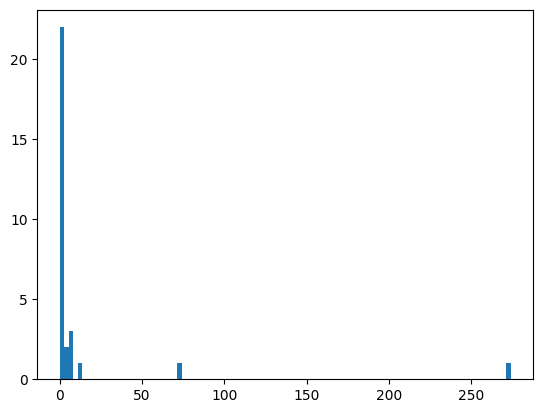

In [70]:
# plt hist
import matplotlib.pyplot as plt

plt.hist(found_indexes, bins=100)
plt.show()

In [71]:
# pd
import pandas as pd

# percentile

pd.Series(found_indexes).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.85, 0.9])

count     30.000000
mean      12.966667
std       51.029054
min        0.000000
10%        0.000000
25%        0.000000
50%        0.000000
75%        2.750000
85%        6.000000
90%        7.500000
max      274.000000
dtype: float64

In [72]:
# ds の正解ラベルを取得

acc_labels_dict = {}
for jacket in jaqket_ds:
    qid = jacket["qid"]
    answers = jacket["answers"]
    rank_data = combined_data[qid]
    acc_labels = {}
    for rank_idx, (pid, v) in enumerate(rank_data.items()):
        ds_index = int(pid)
        target_data = ds[ds_index]
        join_text = target_data["title"] + " " + target_data["text"]
        for answer in answers:
            if answer in join_text:
                acc_labels[pid] = 1
    acc_labels_dict[qid] = acc_labels

In [73]:
list(runs[0]["QA20CAPR-1002"].items())[0:10]

[('2548662', 0.7907533049583435),
 ('4265355', 0.7645919322967529),
 ('4265351', 0.7586060166358948),
 ('1834578', 0.7579162120819092),
 ('1834577', 0.7567729353904724),
 ('3805775', 0.7484675645828247),
 ('2548661', 0.7482423782348633),
 ('4181177', 0.7454358339309692),
 ('3805776', 0.73215651512146),
 ('4181189', 0.7280882000923157)]

In [74]:
list(acc_labels_dict["QA20CAPR-1002"].items())[0:10]

[('2548662', 1),
 ('4265351', 1),
 ('4265355', 1),
 ('3805776', 1),
 ('4265358', 1),
 ('3805775', 1),
 ('3805777', 1),
 ('4181190', 1),
 ('4265359', 1),
 ('4265360', 1)]

In [75]:
from ranx import evaluate, Qrels

qrels = Qrels(acc_labels_dict)

In [76]:
evaluate(qrels, runs[0], "ndcg@100")

0.41963656167442814

In [77]:
runs[0].name, evaluate(qrels, runs[0], "hit_rate@100")

('[debug]intfloat/multilingual-e5-large', 0.9666666666666667)

In [82]:
from ranx import compare

# Compare different runs and perform statistical tests
report = compare(
    qrels=qrels,
    runs=runs,
    metrics=[
        "map@100",
        "map@10",
        "mrr@100",
        "ndcg@10",
        "ndcg@100",
        "hit_rate@1",
        "hit_rate@5",
        "hit_rate@10",
        "hit_rate@20",
        "hit_rate@50",
        "hit_rate@100",
        "hit_rate@500",
    ],
    max_p=0.01,  # P-value threshold
)
print(report.to_table())

#    Model                                  MAP@100    MAP@10      MRR@100  NDCG@10    NDCG@100      Hit Rate@1  Hit Rate@5      Hit Rate@10    Hit Rate@20    Hit Rate@50    Hit Rate@100    Hit Rate@500
---  -------------------------------------  ---------  --------  ---------  ---------  ----------  ------------  ------------  -------------  -------------  -------------  --------------  --------------
a    [debug]intfloat/multilingual-e5-large  0.197ᵇᶜ    0.099ᵇ        0.721  0.502ᵇᶜ    0.420ᵇᶜ            0.6    0.933ᵇᶜ               0.933          0.933          0.967           0.967           0.967
b    [debug]cl-nagoya/sup-simcse-ja-base    0.107      0.049         0.626  0.345      0.269              0.567  0.667                 0.767          0.767          0.833           0.833           1
c    [debug]pkshatech/GLuCoSE-base-ja       0.075      0.044         0.563  0.315      0.220              0.467  0.667                 0.767          0.8            0.9             0.933      

In [ ]:
from ranx import fuse, evaluate, optimize_fusion


# Optimize a given fusion method
best_params = optimize_fusion(
    qrels=qrels,
    runs=runs,
    norm="min-max",  # Default value
    method="wsum",  # Alias for Weighted Sum
    metric="ndcg@100",  # Metric we want to maximize
)

combined_run = fuse(
    runs=runs,
    norm="min-max",  # Default value
    method="wsum",  # Alias for Weighted Sum
    params=best_params,
)

print(combined_run.name, evaluate(qrels, combined_run, "ndcg@100"))

Output()

weighted_sum 0.4191674252009489


In [ ]:
list(combined_run.keys())["0"]

TypeError: list indices must be integers or slices, not str

In [ ]:
# combined_run.keys()["0"]
""

''

In [ ]:
print(combined_run.name, evaluate(qrels, combined_run, "hit_rate@100"))

weighted_sum 0.9804216867469879


In [ ]:
combined_data = combined_run.to_dict()

In [ ]:
combined_data["0"]

{'1458038': 0.7716371100397383,
 '28114': 0.701546325634167,
 '1458036': 0.6311026009808118,
 '4569666': 0.5810220531332259,
 '1458041': 0.5749223874134048,
 '2104489': 0.5578418729421074,
 '268525': 0.544669028177161,
 '4569668': 0.5281532094185969,
 '4569665': 0.47256655818840143,
 '30925': 0.4291126007767105,
 '28111': 0.4053379431328337,
 '1458037': 0.39378237943608607,
 '268527': 0.38910972570890123,
 '213623': 0.3868875351665332,
 '3026652': 0.3798421118819674,
 '2327158': 0.37969484422037575,
 '28112': 0.3584943666972878,
 '923871': 0.3543912502594371,
 '5279': 0.35041092877208235,
 '3022069': 0.3484925606101138,
 '3805680': 0.33117087891028196,
 '4822865': 0.32546779236881973,
 '4345628': 0.32311052365971876,
 '2696366': 0.31584920062789956,
 '1820810': 0.3124803166664136,
 '268524': 0.29473212185892333,
 '4345629': 0.2936918776054584,
 '3026666': 0.2933092126945786,
 '1547166': 0.28642538360244874,
 '4569667': 0.285705779698057,
 '3838622': 0.28172680076623724,
 '58090': 0.280